In [1]:
import tensorflow as tf
import tensorflow.contrib.layers as layers

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
config = tf.ConfigProto(intra_op_parallelism_threads=8, inter_op_parallelism_threads=8, \
                        allow_soft_placement=True, device_count = {'CPU': 8})
sess = tf.InteractiveSession(config = config)

In [4]:
def prepare_data(n_samples):
    data = []
    pois = []
    nuisances = []
    
    for i in range(n_samples):
        sig_bkg = np.random.uniform(low = 0.0, high = 1.0, size = 1)
        if sig_bkg > 0.5:
            nuisance = np.random.uniform(low = 0.0, high = 2.0)
            data.append(np.random.multivariate_normal(mean = [0.0, nuisance], cov = np.array([[1, -0.5], [-0.5, 1]]), size = 1).flatten())
            pois.append(1.0)
        else:
            nuisance = np.random.uniform(low = 0.0, high = 2.0)
            data.append(np.random.multivariate_normal(mean = [1.0, nuisance], cov = np.eye(2), size = 1).flatten())
            pois.append(0.0)
            
        nuisances.append(nuisance)
    data = np.array(data)
    pois = np.array(pois)
    nuisances = np.array(nuisances)
    
    return data, pois, nuisances

In [5]:
data_train, pois_train, nuisances_train = prepare_data(50000)
nuisances_train = np.expand_dims(nuisances_train, axis = 1)
pois_train = np.expand_dims(pois_train, axis = 1)

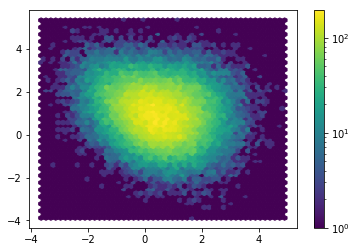

In [6]:
plt.hexbin(x = data_train[:, 0], y = data_train[:, 1], bins = 'log', gridsize = 50)
plt.colorbar()
plt.show()

In [7]:
def MINE_network(data_X, data_Y, name):
    with tf.variable_scope(name):
        data_Y_shuffled = tf.random.shuffle(data_Y)
    
        data_X_combined = tf.concat([data_X, data_X], axis = 0)
        data_Y_combined = tf.concat([data_Y, data_Y_shuffled], axis = 0)
        data_combined = tf.concat([data_X_combined, data_Y_combined], axis = 1)
        
        lay = layers.relu(data_combined, 20)
        lay = layers.relu(lay, 20)
        outputs = layers.linear(lay, 1)
        
    these_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope = name)
    
    return outputs, these_vars

In [8]:
def MINE_loss(MINE_output, name):
    with tf.variable_scope(name):
        batch_size_dyn = tf.cast(tf.math.divide(tf.shape(MINE_output)[0], 2), tf.int32)
        T_xy = MINE_output[:batch_size_dyn,:]
        T_x_y = MINE_output[batch_size_dyn:,:]
        MINE_loss = -(tf.reduce_mean(T_xy, axis = 0) - tf.math.log(tf.reduce_mean(tf.math.exp(T_x_y), axis = 0)))
        MINE_loss = MINE_loss[0]
        
    return MINE_loss

In [9]:
def filter_network(filter_input):
    with tf.variable_scope("filter"):
        lay = layers.relu(filter_input, 20)
        lay = layers.relu(lay, 20)
        outputs = layers.linear(lay, 1)
        
    these_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope = "filter")

    return outputs, these_vars

In [10]:
# prepare input tensors
data_in = tf.placeholder(tf.float32, [None, 2], name = 'data_in')
nuisances_in = tf.placeholder(tf.float32, [None, 1], name = 'nuisances_in')
pois_in = tf.placeholder(tf.float32, [None, 1], name = 'pois_in')

In [11]:
filter_output, filter_vars = filter_network(data_in)

In [12]:
# prepare the two MINE blocks connected to the filter output
MINE_output_nuis, MINE_vars_nuis = MINE_network(filter_output, nuisances_in, "MINE_nuis")
MINE_output_pois, MINE_vars_pois = MINE_network(filter_output, pois_in, "MINE_pois")

In [13]:
# upon convergence, the MINE losses below give the negative mutual information
MINE_loss_nuis = MINE_loss(MINE_output_nuis, "MINE_loss_nuis")
MINE_loss_pois = MINE_loss(MINE_output_pois, "MINE_loss_pois")

In [14]:
# MINE optimizers
train_MINE_pois = tf.train.AdamOptimizer(learning_rate = 0.01, beta1 = 0.3, beta2 = 0.5).minimize(MINE_loss_nuis, var_list = MINE_vars_nuis)
train_MINE_nuis = tf.train.AdamOptimizer(learning_rate = 0.01, beta1 = 0.3, beta2 = 0.5).minimize(MINE_loss_pois, var_list = MINE_vars_pois)

In [15]:
total_loss = MINE_loss_pois - 5 * MINE_loss_nuis

In [16]:
# filter optimizer
train_filter = tf.train.AdamOptimizer(learning_rate = 0.001, beta1 = 0.9, beta2 = 0.999).minimize(total_loss, var_list = filter_vars)

In [17]:
sess.run(tf.global_variables_initializer())

In [18]:
MINE_init_epochs = 200
batches_per_epoch = 200
number_epochs = 10
batch_size = 200

In [19]:
# pre-train MINE blocks
for epoch in range(MINE_init_epochs):
    sess.run(train_MINE_pois, feed_dict = {data_in: data_train, nuisances_in: nuisances_train, pois_in: pois_train})
    sess.run(train_MINE_nuis, feed_dict = {data_in: data_train, nuisances_in: nuisances_train, pois_in: pois_train})

In [20]:
# initial MI values        
MI_pois = -sess.run(MINE_loss_pois, feed_dict = {data_in: data_train, nuisances_in: nuisances_train, pois_in: pois_train})
MI_nuis = -sess.run(MINE_loss_nuis, feed_dict = {data_in: data_train, nuisances_in: nuisances_train, pois_in: pois_train})

print("MI_nuis = {}, MI_pois = {}".format(MI_nuis, MI_pois))

MI_nuis = 0.008573770523071289, MI_pois = 0.03247880935668945


In [21]:
for epochs in range(number_epochs):
    for batch in range(batches_per_epoch):
        # prepare batch training data
        inds = np.random.choice(len(data_train), batch_size)
        data_batch = data_train[inds]
        pois_batch = pois_train[inds]
        nuis_batch = nuisances_train[inds]

        # update MINE
        sess.run(train_MINE_pois, feed_dict = {data_in: data_train, nuisances_in: nuisances_train, pois_in: pois_train})
        sess.run(train_MINE_nuis, feed_dict = {data_in: data_train, nuisances_in: nuisances_train, pois_in: pois_train})

        # update filter
        sess.run(train_filter, feed_dict = {data_in: data_batch, nuisances_in: nuis_batch, pois_in: pois_batch})

        if not batch % 100:
            # debug output
            MI_pois = -sess.run(MINE_loss_pois, feed_dict = {data_in: data_train, nuisances_in: nuisances_train, pois_in: pois_train})
            MI_nuis = -sess.run(MINE_loss_nuis, feed_dict = {data_in: data_train, nuisances_in: nuisances_train, pois_in: pois_train})

            print("MI_nuis = {}, MI_pois = {}".format(MI_nuis, MI_pois))

MI_nuis = 0.009428739547729492, MI_pois = 0.03482246398925781
MI_nuis = 0.0006747245788574219, MI_pois = 0.10272574424743652
MI_nuis = 0.0006961822509765625, MI_pois = 0.11255073547363281
MI_nuis = 0.0005970001220703125, MI_pois = 0.11393594741821289
MI_nuis = 0.0013990402221679688, MI_pois = 0.11620664596557617
MI_nuis = 0.00110626220703125, MI_pois = 0.11766481399536133
MI_nuis = 0.000606536865234375, MI_pois = 0.11716651916503906
MI_nuis = 0.00074005126953125, MI_pois = 0.11373424530029297
MI_nuis = 0.000469207763671875, MI_pois = 0.11478328704833984
MI_nuis = 0.000579833984375, MI_pois = 0.11747074127197266
MI_nuis = 0.0003871917724609375, MI_pois = 0.11325836181640625
MI_nuis = 0.0004863739013671875, MI_pois = 0.1173849105834961
MI_nuis = 0.0007925033569335938, MI_pois = 0.11492061614990234
MI_nuis = 0.0006847381591796875, MI_pois = 0.11310195922851562
MI_nuis = 0.0010137557983398438, MI_pois = 0.11657905578613281
MI_nuis = 0.0005779266357421875, MI_pois = 0.1172027587890625
MI_nu

In [22]:
# look at the filter output as a function of the incoming random variable
#data_test, labels_test, nuisances_test = prepare_data(500000)

In [23]:
# load them from disk instead
data_test = np.loadtxt("data_test.txt")

In [24]:
nuisances_test = np.loadtxt("nuisances_test.txt")

In [25]:
labels_test = np.loadtxt("labels_test.txt")

In [26]:
group1 = np.logical_and(nuisances_test > 0.0, nuisances_test < 0.5)
group2 = np.logical_and(nuisances_test > 0.5, nuisances_test < 1.0)
group3 = np.logical_and(nuisances_test > 1.0, nuisances_test < 1.5)
group4 = np.logical_and(nuisances_test > 1.5, nuisances_test < 2.0)

In [27]:
pred = sess.run(filter_output, feed_dict = {data_in: data_test})

In [28]:
def plot_contour(data_xy, data_z, x_low = -4, x_high = 4 , y_low = -4, y_high = 4):
    from matplotlib.mlab import griddata
    
    xi = np.linspace(x_low, x_high, 1000)
    yi = np.linspace(y_low, y_high, 1000)
    zi = griddata(data_xy[:, 0], data_xy[:, 1], data_z, xi, yi, interp = "linear")

    plt.contourf(xi, yi, zi, interp='linear', levels = 10)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.colorbar()

In [29]:
plot_contour(data_test, pred.flatten())

/usr/lib/python3/dist-packages/ipykernel/__main__.py:6: MatplotlibDeprecationWarning: The griddata function was deprecated in Matplotlib 2.2 and will be removed in 3.1. Use scipy.interpolate.griddata instead.
/home/philipp/.local/lib/python3.5/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'interp'
  s)


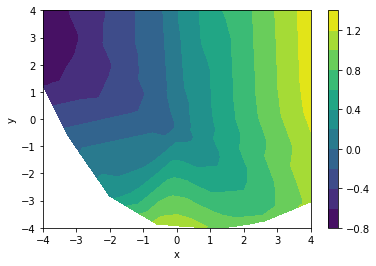

In [30]:
plt.show()

In [31]:
pred1 = sess.run(filter_output, feed_dict = {data_in: data_test[group1]})
pred2 = sess.run(filter_output, feed_dict = {data_in: data_test[group2]})
pred3 = sess.run(filter_output, feed_dict = {data_in: data_test[group3]})
pred4 = sess.run(filter_output, feed_dict = {data_in: data_test[group4]})

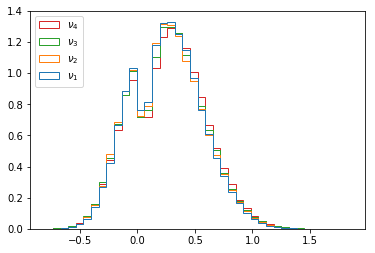

In [32]:
colors = ['red', 'tan', 'lime', 'green']
plt.hist([pred1[:], pred2[:], pred3[:], pred4[:]], label = [r'$\nu_1$', r'$\nu_2$', r'$\nu_3$', r'$\nu_4$'], histtype = 'step', density = True, stacked = False, fill = False, bins = 40)
plt.legend(loc = 'upper left')
plt.show()
#plt.savefig("on.png")

In [33]:
sig = data_test[labels_test == 1]
bkg = data_test[labels_test == 0]

In [34]:
pred_sig = sess.run(filter_output, feed_dict = {data_in: sig})
pred_bkg = sess.run(filter_output, feed_dict = {data_in: bkg})

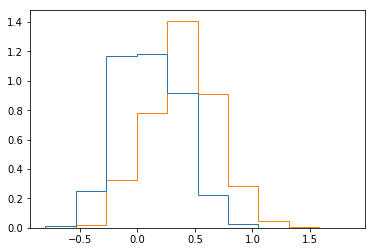

In [35]:
plt.hist([pred_sig[:], pred_bkg[:]], label = ['sig', 'bkg'], histtype = 'step', density = True, stacked = False, fill = False, bins = 10)
plt.show()

In [36]:
# plot ROC curves
from sklearn import metrics

In [37]:
fpr, tpr, thresholds = metrics.roc_curve(labels_test, pred)

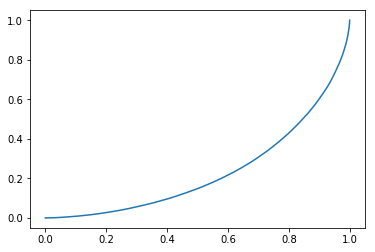

In [38]:
plt.plot(fpr, tpr)
plt.show()

In [45]:
1-metrics.roc_auc_score(labels_test, pred)

0.7681880873964221

In [40]:
# compare it with the exact likelihood
LL_pred = np.loadtxt("LL_evaluated.csv")

In [41]:
fpr_LL, tpr_LL, thresholds_LL = metrics.roc_curve(labels_test, LL_pred)

In [47]:
# plot both of them into the same graph
fig, ax = plt.subplots()
ax.plot(tpr, fpr, label = 'filtered IB', c = 'red')
ax.plot(fpr_LL, tpr_LL, label = 'analytic likelihood', c = 'black', ls = 'dashed')
leg = ax.legend(loc = 'lower right')
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
#plt.show()
plt.savefig("MI_filter_ROC.pdf")